Helper functions to convert the problem into the appropriate Hamiltonian form.


In [32]:
from pyqubo import Spin, Binary, Array
import math
import numpy as np


def basis_to_gram_matrix(basis):
    if not isinstance(basis, np.ndarray):
        raise ValueError("Basis must be a numpy array")
    
    return basis @ basis.T


def gram_to_quadratic_form(gram_matrix):
    x, y = gram_matrix.shape
    if x != y:
        raise ValueError("Gram matrix must be square")
    
    # Diagonal terms
    diag = {}
    for i in range(x):
        diag[i] = gram_matrix[i, i]
    
    # Off-diagonal terms
    off_diag = {}
    for i in range(x):
        for j in range(i + 1, y):
            off_diag[(i, j)] = gram_matrix[i, j] + gram_matrix[j, i]
    
    return diag, off_diag


def substitution_array(variable_name, num_variables, bounds):
    # Handle bounds input
    if isinstance(bounds, (int, float)):
        bounds = [bounds] * num_variables
    elif len(bounds) != num_variables:
        raise ValueError("Bounds list must match number of variables")
    
    substitutions = []
    
    for i, bound in enumerate(bounds):
        num_bits = math.floor(math.log2(2 * bound)) + 1
        
        # Create binary array for this variable
        binary_vars = Array.create(f"{variable_name}_{i}", shape=num_bits, vartype='BINARY')
        
        # Coefficients for the encoding
        coeffs = [2**j for j in range(num_bits - 1)]
        last_coeff = 2 * bound + 1 - 2**math.floor(math.log2(2 * bound))
        coeffs.append(last_coeff)
        
        # Build the substitution expression
        sub = -bound
        for j, coeff in enumerate(coeffs):
            sub += coeff * binary_vars[j]
        
        substitutions.append(sub)
    print(substitutions)
    return substitutions

def substitution_array_for_nonzero(variable_name, num_variables, bounds):
    if isinstance(bounds, (int, float)):
        bounds = [bounds] * num_variables
    elif len(bounds) != num_variables:
        raise ValueError("Bounds list must match number of variables")
    
    substitutions = []
    
    for i, bound in enumerate(bounds):
        # Calculate number of bits needed
        num_bits = math.floor(math.log2(bound - 1)) + 1
        print(f"Nium bits = {num_bits} for bound {bound}")
        
        # Create binary array for this variable
        binary_vars = Array.create(f"{variable_name}_{i}", shape=num_bits + 2, vartype='BINARY')
        
        # x_i = -a_i + ξ_i + ω_i(a + 1) + Σ(2^j * x_ij) + (a_i - 2^⌊log(a_i-1)⌋) * x_i,⌊log(a-1)⌋
        
        # Build the substitution expression
        sub = -bound  # -a_i term
        
        # ξ_i term (first binary variable)
        sub += binary_vars[0]
        
        # ω_i(a + 1) term (second binary variable)
        sub += binary_vars[1] * (bound + 1)
        
        # Σ(2^j * x_ij) terms for j from 0 to ⌊log(a_i-1)⌋-1
        for j in range(num_bits-1):
            sub += (2**j) * binary_vars[j + 2]
        
        # Final term: (a_i - 2^⌊log(a_i-1)⌋) * x_i,⌊log(a-1)⌋
        if num_bits > 0:
            final_coeff = bound - (2**math.floor(math.log2(bound - 1)))
            sub += final_coeff * binary_vars[num_bits + 1]
            print(f"Appending substitution for {final_coeff} * {binary_vars[num_bits + 1]}")
        substitutions.append(sub)
    print(substitutions)
    return substitutions

def gram_to_hamiltonian(gram_matrix, bounds, variable_name='x'):
    n = gram_matrix.shape[0]
    
    # Convert Gram matrix to quadratic form
    diagonal_terms, off_diagonal_terms = gram_to_quadratic_form(gram_matrix)
    
    # Create substitutions - special non-zero substitution only for x_0
    substitutions = []
    
    for i in range(n):
        # if False: USE THIS IF YOU WANT TO USE THE NORMAL SUBSTITUTION
        if i == 0:
            # Use special non-zero substitution for x_0
            # Extract the bound for this variable and ensure it's a scalar
            if isinstance(bounds, (list, np.ndarray)) and len(bounds) > 1:
                bound_for_i = int(bounds[0])  # Convert to Python int
            else:
                bound_for_i = int(bounds) if isinstance(bounds, np.ndarray) else bounds
            special_sub = substitution_array_for_nonzero(f"{variable_name}_control", 1, bound_for_i)
            substitutions.append(special_sub[0])
        else:
            # Use regular substitution for all other variables
            # Extract the bound for this variable and ensure it's a scalar
            if isinstance(bounds, (list, np.ndarray)) and len(bounds) > 1:
                bound_for_i = int(bounds[i])  # Convert to Python int
            else:
                bound_for_i = int(bounds) if isinstance(bounds, np.ndarray) else bounds
            # FIX: Include the variable index in the variable name
            regular_sub = substitution_array(f"{variable_name}_{i}", 1, bound_for_i)
            substitutions.append(regular_sub[0])
    
    # Build the Hamiltonian
    hamiltonian = 0
    
    # Add penalty for the first binary variable of x_0 (x_control_0) = 1
    # This corresponds to the ξ_0 term in the non-zero encoding
    if len(substitutions) > 0:  # Ensure x_0 exists
        # Create the first binary variable for the penalty
        penalty_var = Binary(f"{variable_name}_control_0[0]")  # First binary var of first special variable
        hamiltonian += 40 * penalty_var  # Penalty of 5 when this binary variable = 1
        # testing_var = Binary(f"{variable_name}_0[0]")  # Second binary var of first special variable
        ## CHANGE THIS TO USE PENALITY VAR, UNCOMMENT THE ABOVE LINES
    
    # Add diagonal terms (quadratic terms like ax²)
    for i, coeff in diagonal_terms.items():
        hamiltonian += coeff * (substitutions[i] ** 2)
    
    # Add off-diagonal terms (cross terms like bxy)
    for (i, j), coeff in off_diagonal_terms.items():
        hamiltonian += coeff * substitutions[i] * substitutions[j]
    
    
    
    
    # Compile the model
    model = hamiltonian.compile()
    return model


def generate_qubo_from_gram_matrix_array(gram_matrix, bounds, variable_name='x'):
    model = gram_to_hamiltonian(gram_matrix, bounds, variable_name)
    qubo_dict, offset = model.to_qubo()
    
    return qubo_dict, offset
def generate_ising_from_gram_matrix_array(gram_matrix, bounds, variable_name='x'):
    model = gram_to_hamiltonian(gram_matrix, bounds, variable_name)
    linear, quadratic, offset = model.to_ising()
    
    return linear , quadratic, offset

def basis_to_ising(basis, bounds, variable_name='x'):
    gram_matrix = basis_to_gram_matrix(basis)
    return generate_ising_from_gram_matrix_array(gram_matrix, bounds, variable_name)

CONVERT TO APPROPRIATE QISKIT FORM

In [64]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
import re

def ising_to_sparse_pauli_op(linear_terms, quadratic_terms, offset):
    # Extract all variable names and map them to qubit indices
    all_vars = set()
    for var in linear_terms.keys():
        all_vars.add(var)
    for var_pair in quadratic_terms.keys():
        all_vars.update(var_pair)
    
    # Sort variables to ensure consistent ordering
    sorted_vars = sorted(list(all_vars))
    
    print("Sorted variables:", sorted_vars)
    
    # Create mapping from variable name to qubit index
    var_to_qubit = {var: i for i, var in enumerate(sorted_vars)}
    n_qubits = len(sorted_vars)

    
    pauli_list = []
    
    # Add constant term (identity operator)
    if offset != 0:
        identity_string = 'I' * n_qubits
        pauli_list.append([identity_string, offset])
    
    # Add linear terms (single Z operators)
    for var, coeff in linear_terms.items():
        pauli_string = ['I'] * n_qubits
        qubit_idx = var_to_qubit[var]
        pauli_string[qubit_idx] = 'Z'
        pauli_list.append([''.join(pauli_string), coeff])
    
    # Add quadratic terms (ZZ operators)
    for (var1, var2), coeff in quadratic_terms.items():
        pauli_string = ['I'] * n_qubits
        qubit_idx1 = var_to_qubit[var1]
        qubit_idx2 = var_to_qubit[var2]
        pauli_string[qubit_idx1] = 'Z'
        pauli_string[qubit_idx2] = 'Z'
        pauli_list.append([''.join(pauli_string), coeff])
    
    return SparsePauliOp.from_list(pauli_list)

basis = np.array([[-5, -2, 20], [-2, 5, 7], [6, -1, 6]])
# basis = np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
bound = np.array([3,3,3])
ising = basis_to_ising(basis, bound)


print("Raw ising output:")
print(ising)
print()

# Unpack the result
linear_terms, quadratic_terms, offset = ising

print("Linear terms:", linear_terms)
print("Quadratic terms:", list(quadratic_terms.keys()))  # Show first 5 keys
print("Offset:", offset)
print()

# Convert to SparsePauliOp
ising_op =  ising_to_sparse_pauli_op(linear_terms, quadratic_terms, offset)
print("SparsePauliOp:")
print(ising_op)

Nium bits = 2 for bound 3
Appending substitution for 1 * Binary('x_control_0[3]')
[((1.000000 * Binary('x_control_0[3]')) + (1.000000 * Binary('x_control_0[2]')) + (Binary('x_control_0[1]') * 4.000000) + -3.000000 + Binary('x_control_0[0]'))]
[((3.000000 * Binary('x_1_0[2]')) + (2.000000 * Binary('x_1_0[1]')) + -3.000000 + (1.000000 * Binary('x_1_0[0]')))]
[((3.000000 * Binary('x_2_0[2]')) + (2.000000 * Binary('x_2_0[1]')) + -3.000000 + (1.000000 * Binary('x_2_0[0]')))]
Raw ising output:
({'x_2_0[1]': 92.0, 'x_1_0[1]': 140.0, 'x_2_0[0]': 46.0, 'x_1_0[0]': 70.0, 'x_1_0[2]': 210.0, 'x_2_0[2]': 138.0, 'x_control_0[0]': 234.5, 'x_control_0[1]': 858.0, 'x_control_0[2]': 214.5, 'x_control_0[3]': 214.5}, {('x_1_0[0]', 'x_1_0[2]'): 117.0, ('x_1_0[1]', 'x_control_0[1]'): 560.0, ('x_1_0[0]', 'x_2_0[0]'): 12.5, ('x_1_0[0]', 'x_2_0[1]'): 25.0, ('x_1_0[0]', 'x_1_0[1]'): 78.0, ('x_1_0[0]', 'x_2_0[2]'): 37.5, ('x_1_0[0]', 'x_control_0[0]'): 70.0, ('x_1_0[0]', 'x_control_0[1]'): 280.0, ('x_1_0[1]', 'x

CVar Optimization

===time to run programme===
  - QAOA layers (reps): 2
  - Use CVaR optimization: True
  - CVaR risk level (alpha): 0.25
  - CVaR shots per evaluation: 1024

QAOA circuit has 4 parameters
Circuit depth: 50
Number of qubits: 10
Using CVaR optimization:
  - Risk level (alpha): 0.25 (focusing on best 25.0% of solutions)
  - Shots per evaluation: 1024
Initial parameters: [0.14812458 0.40453386 0.17512626 0.39470463]
Testing objective function...
Initial CVaR: 506.930
Starting optimization...
\nOptimization completed!
   Normal return from subroutine COBYLA


Success: True
Optimal CVaR: 422.035
CVaR improvement: 84.895
Message: Optimization terminated successfully.
\nProceeding with final sampling...
Sampling from optimized state...
   NFVALS =   44   F = 4.220352E+02    MAXCV = 0.000000E+00
   X = 1.153017E+00   1.520887E+00   9.579355E-01   3.508075E-01
\nTop 10 most frequent solutions (from 1024 shots):
 1. 1101000100:  10 counts (1.0%), cost = 332.0
 2. 1000100011:  10 counts (1.0%), cos

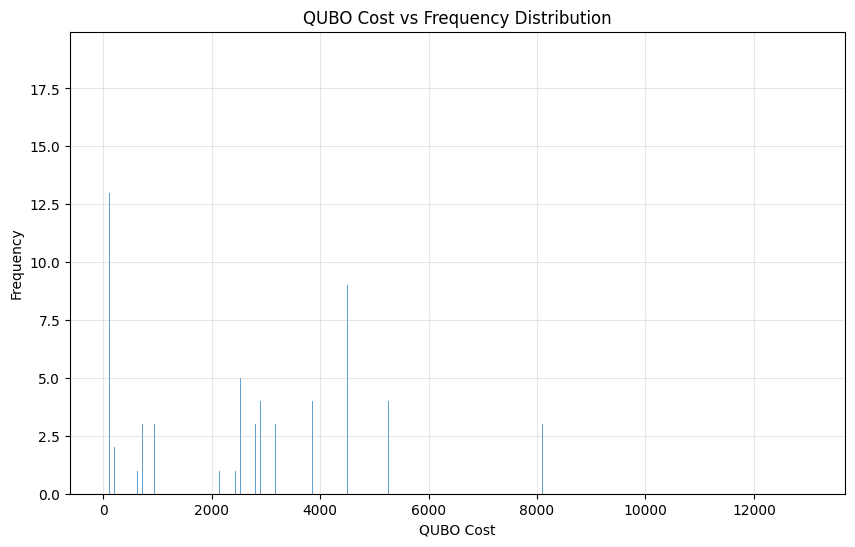

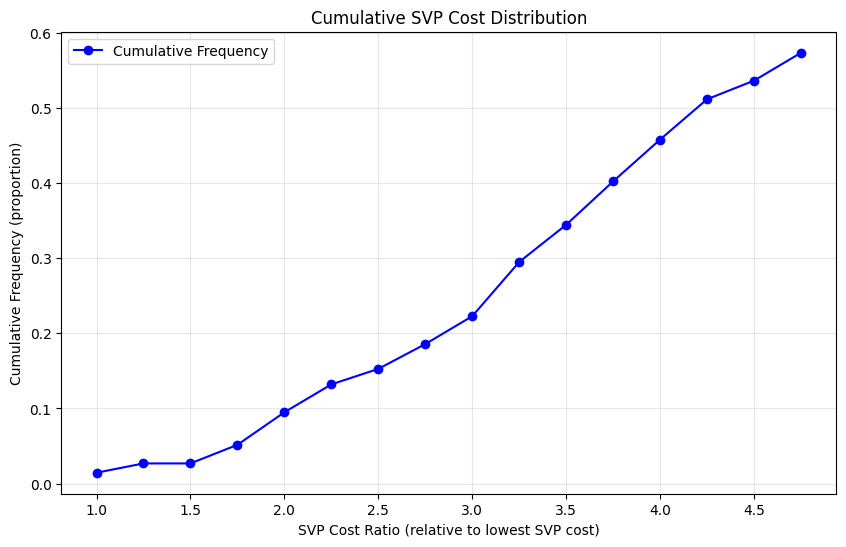

1. 0010010100: cost = 40.0, frequency = 6 (0.6%)
2. 1100010100: cost = 40.0, frequency = 6 (0.6%)
3. 0011100100: cost = 40.0, frequency = 2 (0.2%)
4. 1101100100: cost = 40.0, frequency = 1 (0.1%)
5. 0011010100: cost = 113.0, frequency = 9 (0.9%)
6. 1101010100: cost = 113.0, frequency = 3 (0.3%)
7. 0010100100: cost = 113.0, frequency = 1 (0.1%)
8. 1100100100: cost = 113.0, frequency = 1 (0.1%)
9. 0101100100: cost = 118.0, frequency = 7 (0.7%)
10. 1011100100: cost = 118.0, frequency = 4 (0.4%)
11. 0100010100: cost = 118.0, frequency = 1 (0.1%)
12. 1010010100: cost = 118.0, frequency = 1 (0.1%)
13. 1010100100: cost = 141.0, frequency = 2 (0.2%)
14. 0101010100: cost = 141.0, frequency = 1 (0.1%)
15. 1011011011: cost = 166.0, frequency = 3 (0.3%)
16. 0111011011: cost = 170.0, frequency = 1 (0.1%)
17. 1000101100: cost = 170.0, frequency = 1 (0.1%)
18. 1000011100: cost = 181.0, frequency = 1 (0.1%)
19. 1001101100: cost = 181.0, frequency = 1 (0.1%)
20. 0100100110: cost = 206.0, frequency = 1 

In [66]:
import numpy as np
from qiskit.circuit.library import QAOAAnsatz #Defines the starting point for QAOA circuits
from qiskit.primitives import StatevectorEstimator, StatevectorSampler #Whats the difference?
from scipy.optimize import minimize #COBYLA and Powell optimization methods
import matplotlib.pyplot as plt #plotting results

def create_qaoa_circuit(cost_operator, reps=1):

    return QAOAAnsatz(
        cost_operator=cost_operator,
        reps=reps,
        flatten=True  # IMPORTANT for performance!
    )

def create_sampling_circuit(qaoa_ansatz, parameters):
    """Create circuit with measurements for final sampling"""
    bound_circuit = qaoa_ansatz.assign_parameters(parameters)
    bound_circuit.measure_all()
    return bound_circuit


def objective_function_fixed(parameters, qaoa_ansatz, cost_operator, use_cvar=True, alpha=0.25, shots=1024):

    if not use_cvar:
        # Original expectation value approach
        estimator = StatevectorEstimator()
        
        # Handle layout for hardware compatibility
        if hasattr(qaoa_ansatz, 'layout') and qaoa_ansatz.layout is not None:
            isa_hamiltonian = cost_operator.apply_layout(qaoa_ansatz.layout)
        else:
            isa_hamiltonian = cost_operator
        
        # Use the pub format
        pub = (qaoa_ansatz, isa_hamiltonian, parameters)
        job = estimator.run([pub])
        results = job.result()[0]
        
        return float(results.data.evs)
    
    else:
        # CVaR approach: sample and focus on best solutions
        
        # Create sampling circuit with measurements
        bound_circuit = qaoa_ansatz.assign_parameters(parameters)
        bound_circuit.measure_all()
        
        # Sample from the quantum state
        sampler = StatevectorSampler()
        job = sampler.run([bound_circuit], shots=shots)
        counts = job.result()[0].data.meas.get_counts()
        
        # Evaluate costs for all sampled bitstrings
        costs = []
        for bitstring, count in counts.items():
            cost = evaluate_bitstring_cost(bitstring, cost_operator)
            costs.extend([cost] * count)  # Repeat cost for each occurrence
        
        # Convert to numpy array and sort
        costs = np.array(costs)
        costs_sorted = np.sort(costs)
        
        # Calculate cutoff for best α fraction
        cutoff_index = int(alpha * len(costs))
        if cutoff_index == 0:
            cutoff_index = 1
        
        # CVaR: average of the best α fraction of solutions
        cvar_value = np.mean(costs_sorted[:cutoff_index])
        
        return float(cvar_value)

    
    
def run_qaoa_optimization(cost_operator, reps=1, max_iterations=500, use_cvar=True, cvar_alpha=0.25, cvar_shots=1024):
    """
    MODIFIED: Added CVaR parameters
    Complete QAOA optimization workflow with CVaR support
    
    Args:
        cost_operator: The cost Hamiltonian
        reps: Number of QAOA layers
        max_iterations: Maximum optimization iterations
        use_cvar: If True, use CVaR objective function
        cvar_alpha: CVaR risk level (0.1 = best 10%, 0.25 = best 25%)
        cvar_shots: Number of shots for CVaR sampling
    """
    
    # Create QAOA ansatz (using your original simple version)
    qaoa_ansatz = create_qaoa_circuit(cost_operator, reps=reps)
    
    print(f"QAOA circuit has {qaoa_ansatz.num_parameters} parameters")
    print(f"Circuit depth: {qaoa_ansatz.depth()}")
    print(f"Number of qubits: {qaoa_ansatz.num_qubits}")
    
    if use_cvar:
        print(f"Using CVaR optimization:")
        print(f"  - Risk level (alpha): {cvar_alpha} (focusing on best {cvar_alpha*100:.1f}% of solutions)")
        print(f"  - Shots per evaluation: {cvar_shots}")
    else:
        print("Using standard expectation value optimization")
    
    # Better parameter initialization for QAOA
    np.random.seed(69)
    initial_params = np.random.uniform(0, 0.5, qaoa_ansatz.num_parameters)
    print(f"Initial parameters: {initial_params}")
    
    # Test objective function
    print("Testing objective function...")
    initial_energy = objective_function_fixed(initial_params, qaoa_ansatz, cost_operator, 
                                            use_cvar=use_cvar, alpha=cvar_alpha, shots=cvar_shots)
    print(f"Initial {'CVaR' if use_cvar else 'energy'}: {initial_energy:.3f}")
    
    # Run optimization
    print("Starting optimization...")
    
    # Try COBYLA first (good for QAOA)
    result = minimize(
        objective_function_fixed,
        initial_params,
        args=(qaoa_ansatz, cost_operator, use_cvar, cvar_alpha, cvar_shots),
        method='COBYLA',
        options={'maxiter': max_iterations, 'disp': True}
    )
    
    # If COBYLA didn't converge, try Powell
    if not result.success and result.nfev >= max_iterations * 0.8:
        print("\\nCOBYLA hit max iterations, trying Powell method...")
        result = minimize(
            objective_function_fixed,
            result.x,  # Start from COBYLA result
            args=(qaoa_ansatz, cost_operator, use_cvar, cvar_alpha, cvar_shots),
            method='Powell',
            options={'maxiter': max_iterations//2, 'disp': True}
        )
    
    print(f"\\nOptimization completed!")
    print(f"Success: {result.success}")
    print(f"Optimal {'CVaR' if use_cvar else 'energy'}: {result.fun:.3f}")
    print(f"{'CVaR' if use_cvar else 'Energy'} improvement: {initial_energy - result.fun:.3f}")
    print(f"Message: {result.message}")
    
    return result, qaoa_ansatz


def sample_final_results(qaoa_ansatz, optimal_params, shots=1000):
    """Sample from the optimized quantum state"""
    
    # Create sampling circuit with measurements
    sampling_circuit = create_sampling_circuit(qaoa_ansatz, optimal_params)
    
    # Use StatevectorSampler for sampling
    sampler = StatevectorSampler()
    job = sampler.run([sampling_circuit], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    
    return counts

def evaluate_bitstring_cost(bitstring, cost_operator):
    """Evaluate the actual cost of a solution bitstring"""
    z_values = [1 if bit == '0' else -1 for bit in bitstring]
    
    cost = 0
    for pauli_string, coeff in zip(cost_operator.paulis, cost_operator.coeffs):
        term_value = 1
        for i, pauli in enumerate(str(pauli_string)):
            if pauli == 'Z':
                term_value *= z_values[i]
        cost += coeff.real * term_value
    
    return cost

# Example usage with your ising_op from previous cells
def complete_qaoa_workflow(ising_op, reps=1, use_cvar=True, cvar_alpha=0.25, cvar_shots=1024):
    
    print(f"  - QAOA layers (reps): {reps}")
    print(f"  - Use CVaR optimization: {use_cvar}")
    if use_cvar:
        print(f"  - CVaR risk level (alpha): {cvar_alpha}")
        print(f"  - CVaR shots per evaluation: {cvar_shots}")
    print()
    
    # Run optimization
    result, qaoa_ansatz = run_qaoa_optimization(ising_op, reps=reps, max_iterations=500,
                                              use_cvar=use_cvar,
                                              cvar_alpha=cvar_alpha,
                                              cvar_shots=cvar_shots)
    
    print(f"\\nProceeding with final sampling...")
    
    # Sample from optimized state (always use more shots for final analysis)
    print("Sampling from optimized state...")
    final_shots = max(cvar_shots, 1000)  # Use at least 1000 shots for final sampling
    counts = sample_final_results(qaoa_ansatz, result.x, shots=final_shots)
    
    # Analyze top solutions
    print(f"\\nTop 10 most frequent solutions (from {final_shots} shots):")
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    def decode_bitstring(bits): #sorry this is manually coded, please improve this since this needs to change for different bounds
        def flip(b):
            return 1 - b
        if isinstance(bits, str):
            bits = [flip(int(b)) for b in bits]
        term1 = bits[0:3]
        value1 = -3 + bits[0] + 2 * bits[1] + 3 * bits[2]
        term2 = bits[3:6]
        value2 = -3 + bits[3] + 2 * bits[4] + 3 * bits[5]
        term3 = bits[6:10]
        control_value = -3 + bits[6] + 4 * bits[7] + bits[8] + bits[9]
        
        return np.array([value1, value2, control_value])
    
    
    SVP_costs = []
    
    for i, (bitstring, count) in enumerate(sorted_counts[:10]):
        probability = count / final_shots
        actual_cost = evaluate_bitstring_cost(bitstring, ising_op)
        print(f"{i+1:2d}. {bitstring}: {count:3d} counts ({probability:.1%}), cost = {actual_cost:.1f}")
    
    for i, (bitstring, count) in enumerate(sorted_counts):
        SVP_cost = np.linalg.norm(decode_bitstring(bitstring) @ basis) # Calculate SVP cost using l2 norm
        SVP_costs.append(SVP_cost)
    
    
    
    # Find the best solution by actual cost
    print("Best solutions by actual cost:")
    cost_sorted = [(bs, cnt, evaluate_bitstring_cost(bs, ising_op)) 
                   for bs, cnt in sorted_counts]
    cost_sorted.sort(key=lambda x: x[2])  # Sort by cost
    cost_freq_dict = {}
    for item in cost_sorted:
        cost = item[2]
        freq = item[1]
        cost_freq_dict[cost] = cost_freq_dict.get(cost, 0) + freq
    
    # Convert back to lists
    costs = list(cost_freq_dict.keys())
    frequencies = list(cost_freq_dict.values())
    plt.figure(figsize=(10, 6))
    plt.bar(costs, frequencies, alpha=0.7)
    plt.xlabel('QUBO Cost')
    plt.ylabel('Frequency')
    plt.title('QUBO Cost vs Frequency Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.figure(figsize=(10, 6))
    
    SVP_costs = [cost for cost in SVP_costs if abs(cost) > 1e-10]  # Remove near-zero costs with numerical tolerance
    lowest_svp_cost = min(SVP_costs) if SVP_costs else float('inf')  # Handle empty list case
    print(f"Number of non-zero SVP costs: {len(SVP_costs)}")
    print(f"SVP costs range: {min(SVP_costs):.3f} to {max(SVP_costs):.3f}")
    print(f"Lowest SVP cost: {lowest_svp_cost:.1f}")
    svp_ratios = []
    for i in range(4,20): #can vary 100 to get more ratios
        svp_ratios.append(i/4*lowest_svp_cost)
    svp_cum_freq = []
    for ratio in svp_ratios:
        svp_cum_freq.append(sum(1 for cost in SVP_costs if cost <= ratio))
    # Plot cumulative frequency line
    plt.plot([x/abs(lowest_svp_cost) for x in svp_ratios], [x/len(SVP_costs) for x in svp_cum_freq], color='blue', marker='o', label='Cumulative Frequency')
    plt.xlabel('SVP Cost Ratio (relative to lowest SVP cost)')
    plt.ylabel('Cumulative Frequency (proportion)')
    plt.title('Cumulative SVP Cost Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    

    
    
    
    
    
    
    
    
    
    for i, (bitstring, count, cost) in enumerate(cost_sorted[:30]):
        probability = count / final_shots
        print(f"{i+1}. {bitstring}: cost = {cost:.1f}, frequency = {count} ({probability:.1%})")
    
    # CVaR analysis
    if use_cvar:
        print(f"CVAR ANALYSIS")
        
        # Calculate actual CVaR from final sampling
        all_costs = []
        for bitstring, count in sorted_counts:
            cost = evaluate_bitstring_cost(bitstring, ising_op)
            all_costs.extend([cost] * count)
        
        all_costs = np.array(all_costs)
        all_costs_sorted = np.sort(all_costs)
        
        # CVaR for different risk levels
        for alpha in [0.1, 0.25, 0.5]:
            cutoff = int(alpha * len(all_costs))
            if cutoff == 0:
                cutoff = 1
            cvar_val = np.mean(all_costs_sorted[:cutoff])
            print(f"CVaR (α={alpha}): {cvar_val:.1f} (best {alpha*100:.0f}% of solutions)")
        
        print(f"Mean cost: {np.mean(all_costs):.1f}")
        print(f"Best cost found: {np.min(all_costs):.1f}")
        print(f"Worst cost found: {np.max(all_costs):.1f}")
    
    return result, sorted_counts
# Run the complete workflow
print("===time to run programme===")
#optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=5)
# Standard CVaR optimization (recommended)
# Test CVaR with your existing setup
optimization_result, top_solutions = complete_qaoa_workflow(
    ising_op, 
    reps=2,
    use_cvar=True,           # Enable CVaR
    cvar_alpha=0.25,         # Focus on best 25%
    cvar_shots=1024          # Shots per evaluation
)

In [ ]:
# def decode_bitstring(bits):
#     def flip(b):
#         return 1 - b
#     if isinstance(bits, str):
#         bits = [flip(int(b)) for b in bits]
#     term1 = bits[0:3]
#     value1 = -3 + bits[0] + 2 * bits[1] + 3 * bits[2]
#     term2 = bits[3:6]
#     value2 = -3 + bits[3] + 2 * bits[4] + 3 * bits[5]
#     term3 = bits[6:10]
#     control_value = -3 + bits[6] + 4 * bits[7] + bits[8] + bits[9]
    
#     return np.array([value1, value2, control_value])

# # Test with one of the top solutions from the QAOA result
# bitstring = '1101101100'  # One of the solutions from top_solutions
# decoded = decode_bitstring(bitstring) @ basis
# print(decoded)
# l2_norm = np.linalg.norm(decoded)
# print(f"\nL2 norm of decoded vector: {l2_norm}")


[ 0  0 -2]

L2 norm of decoded vector: 2.0
